# ChromSTEM Data Preprocessing Pipline
## Load all packages

In [122]:
from utils_pre import *
import sys
rootDir = os.getcwd().split('Demo')[0]
if rootDir not in sys.path:  # add parent dir to paths
    sys.path.append(rootDir)

In this demo, Let's take a look at cell 3 at `BJCells_DishB_09_01_2022`

In [123]:
base_path = f"../Dataset/BJCells_DishB_09_01_2022"
PWS_Path = f"{base_path}/PWSimages"
DV_Path = f"{base_path}/DVimages"
Result_Path = f"{base_path}/Results"

## Data Normalization
Before we begin, to normalize the data, we need to measure the maximum and minimum values of the PWS/Confocal image in `BJCells_DishB_09_01_2022`:
$$norm\_img = \frac{img}{dataset\_max-dataset\_min}$$

Here we've calculated the maximum and minimum of the `BJCells_DishB_09_01_2022` in advance:
$$dataset\_range = [PWS.max-PWS.min, DV.max-DV.min]$$

In [124]:
dataset_range = [0.7677323818206787, 9044.3330078125]

In [125]:
folder='Cell03'
cell3 = preprocess(PWS_Path, DV_Path, instance=folder)
print(f"All data file available: {cell3.data_availability(folder, False)}")

All data file available: True


## Run the data preprocessing pipline

In [126]:
cell3.preprocessing_pipline(n=3,
                           output_size=[512, 512],
                           level_iters=[200, 100, 50, 25],
                           inv_iter=50,
                           norm_range=dataset_range,
                           save=False
                           )

After running the pipline, you can access:
* `pws_cell`: Masked raw pws cell image
* `dv_info`: A dict include $n$ selected DV images from the DV image series; The average of selected DV images; The average mask for selected DV images
* `cropped_pws`: Cropped and resize PWS image
* `cropped_dv`: Cropped DV image
* `padded_pws`: Padding the cropped PWS image to [512, 512]
* `padded_dv`: Padding the cropped DV image to [512, 512]
* `registered_pws`: Registered pws image (refer to dv)

Let's check `cell3.padded_dv` and `cell3.registered_pws`. Later, in our further experiment, we will use those data to train our model

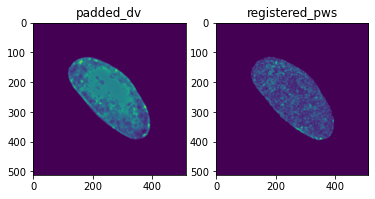

In [127]:
double_img_show(cell3.padded_dv, cell3.registered_pws, t1="padded_dv", t2="registered_pws")

## Step by Step Explaination (Cell01)
Here, we'll take a step by step look at data preprocessing of another cell (Cell05):
```python
:param n: int
        number of selected confocal images
:param output_size: list of int
        the output size of both confocal/pws image
:param level_iters : list of int
        the number of iterations at each level of the Gaussian Pyramid (the
        length of the list defines the number of pyramid levels to be
        used)
:param inv_iter : int
        the number of iterations to be performed by the displacement field
        inversion algorithm
:param norm_range: list of float
        a list contains [pws.max-pws.min, dv.max-dv.min]
:param save: bool
        whether save the output images or not
:return: None```

In [128]:
folder='Cell01'

### 1. Check data availbility
Some folder may lack corresponding files. Here, we will check the existence of all required files and record the test results in the `./Processed/diagnose/*.txt`.

In [129]:
cell1 = preprocess(PWS_Path, DV_Path, instance=folder)
print(f"All data file available: {cell1.data_availability(folder, False)}")

All data file available: True


### 2. Load files

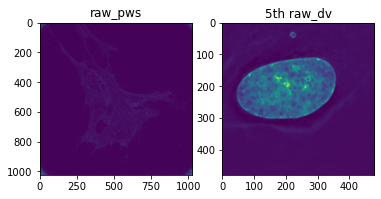

In [130]:
cell1.read_file()
double_img_show(cell1.pws, # 1024×1024
                cell1.dv[5], # 14×480×480
                'raw_pws',
                '5th raw_dv')

### 3. Apply mask to raw data and match 3 most similar confocal images
In this part, we need to mask the pws raw data to **match and select** 3 confocal masks from the confocal series that have the most similar shape to the pws mask.

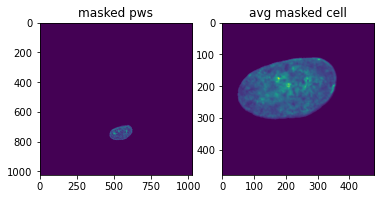

In [131]:
pws_cell, dv_info=cell1.apply_mask_and_select(n=3, dialation=True)
double_img_show(pws_cell, # 1024×1024
                dv_info['avg_masked_cell'], # 480×480
                'masked pws',
                'avg masked cell')

The matching is base on the 7 Hu moment invariants $I = [I_1, I_2,...,I_7]$ of the binary masks, which are contructed based on the normalized central moments.

To begin with, for a digital image $f(x,y)$, the central moments are defined as:
$$\mu_{p q}=\sum_x \sum_y(x-\bar{x})^p(y-\bar{y})^q f(x, y)$$
where $\bar{x}=\frac{M_{10}}{M_{00}}$ and $\bar{y}=\frac{M_{01}}{M_{00}}$, and it is **translate invariant**.

Then, we normalize it and make it to be **scale invariant** by dividing through a properly scaled zero-th central moment.
$$
\eta_{i j}=\frac{\mu_{i j}}{\mu_{00}^{\left(1+\frac{i+j}{2}\right)}}
$$
where, $i+j>=2$

Finally, the **rotaion invariance** can be obtained by properly combine the normalized central moments of order up to 3:
$$
\begin{aligned}
& I_1=\eta_{20}+\eta_{02} \\
& I_2=\left(\eta_{20}-\eta_{02}\right)^2+4 \eta_{11}^2 \\
& I_3=\left(\eta_{30}-3 \eta_{12}\right)^2+\left(3 \eta_{21}-\eta_{03}\right)^2 \\
& I_4=\left(\eta_{30}+\eta_{12}\right)^2+\left(\eta_{21}+\eta_{03}\right)^2 \\
& I_5=\left(\eta_{30}-3 \eta_{12}\right)\left(\eta_{30}+\eta_{12}\right)\left[\left(\eta_{30}+\eta_{12}\right)^2-3\left(\eta_{21}+\eta_{03}\right)^2\right]+\left(3 \eta_{21}-\eta_{03}\right)\left(\eta_{21}+\eta_{03}\right)\left[3\left(\eta_{30}+\eta_{12}\right)^2-\left(\eta_{21}+\eta_{03}\right)^2\right] \\
& I_6=\left(\eta_{20}-\eta_{02}\right)\left[\left(\eta_{30}+\eta_{12}\right)^2-\left(\eta_{21}+\eta_{03}\right)^2\right]+4 \eta_{11}\left(\eta_{30}+\eta_{12}\right)\left(\eta_{21}+\eta_{03}\right) \\
& I_7=\left(3 \eta_{21}-\eta_{03}\right)\left(\eta_{30}+\eta_{12}\right)\left[\left(\eta_{30}+\eta_{12}\right)^2-3\left(\eta_{21}+\eta_{03}\right)^2\right]-\left(\eta_{30}-3 \eta_{12}\right)\left(\eta_{21}+\eta_{03}\right)\left[3\left(\eta_{30}+\eta_{12}\right)^2-\left(\eta_{21}+\eta_{03}\right)^2\right]
\end{aligned}
$$
 $I_1$ is analogous to the moment of inertia around the image's centroid, where the pixels' intensities are analogous to physical density. The first six, $I_1 ... I_6$, are reflection symmetric, i.e. they are unchanged if the image is changed to a mirror image. The last one, $I_7$, is reflection antisymmetric, which enables it to distinguish mirror images of otherwise identical images.


### 4. Crop the image to ensure that the edge of the cell is at the edge of the image, and resize PWS

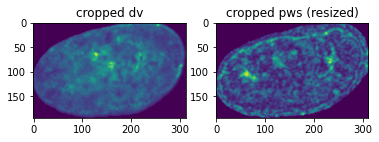

In [132]:
cropped_dv, cropped_pws = cell1.apply_cropping(resize=True)
double_img_show(cropped_dv, # 278×278 depends on the image
                cropped_pws, # 278×278 depends on the image
                'cropped dv',
                'cropped pws (resized)')

### 5. Padding the image to ensure the image are in the same size [512×512]
At this point, basically we can see that these two images have roughly the same shape.

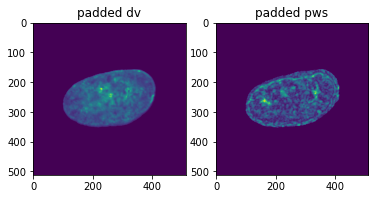

In [133]:
padded_dv, padded_pws = cell1.padding2same_size(desired_size=[512,512])
double_img_show(padded_dv, # 278×278 to 512×512
                padded_pws, # 278×278 to 512×512
                'padded dv',
                'padded pws')

### 6. PWS registration using Symmetric diffeomorphic image registration
Reference: [https://doi.org/10.1016/j.media.2007.06.004](https://doi.org/10.1016/j.media.2007.06.004)

But, if you overlay them together, they're not exactly the same shape (figure above). This results in a trained generated model, and the resulting image will have a circle of blurred edges

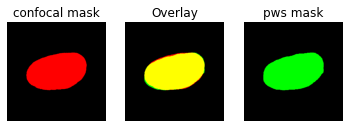

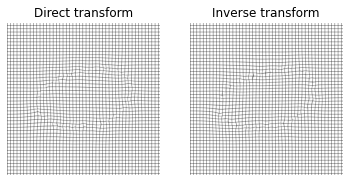

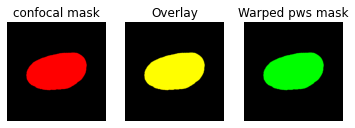

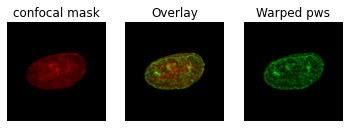

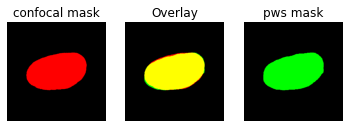

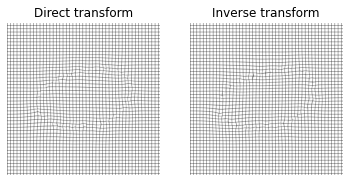

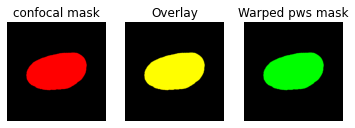

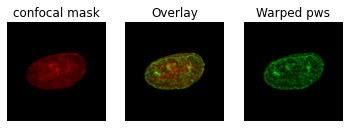

In [134]:
registered_pws = cell1.image_registration(level_iters=[200,100,50,25], inv_iter=50, visualization=True)

In this step, we used confocal mask and pws mask to generate a deformation field $\phi$. And apply this deformation field $\phi$ to the padded PWS image to finish the registration. The agorithm is illustrated below:

#### Symmetric diffeomorphic image registration
While diffeomorphisms are theoretically guaranteed to be invertible, interpolation errors can lead to invertibility errors that increase linearly with the number of interpolation steps. this method, on the other hand, directly minimizes this error by exploiting the invertibility guaranteed by diffeomorphisms. Symmetry is required for distance estimates and makes results independent of arbitrary decisions about which image is ‘‘source’’ or ‘‘reference.’’

##### Problem statement (in our occasion)
We want to find a spatiotemporal mapping $\phi$ between PWS image, $I$, and Confocal (dv), $J$, such that minimize the selected similarity metrics,$\Pi(I, J)$. In our case we are using two binary images, so the Sum of Squared Differences (SSD) is a good choice for our similarity metric $\Pi(I, J)$.

##### Symmetric diffeomorphic

To make this process symmetric, the image registration is defined in a time zone of $t \in[0,1]$, where t indexes both, $\phi_1$ and $\phi_2$, though opposite directions.

![avatar](https://ars.els-cdn.com/content/image/1-s2.0-S1361841507000606-gr1.jpg)

That turns the optimization problem into, how to make the middle state of both forwar and backward process to be the same:
$$
I \circ \phi_1(\cdot, 0.5)= J \circ \phi_2(\cdot, 0.5)
$$

##### Model in terms of the flow of transformation

Note that, in the field of medical imaging, the reversibility of image registration is a desired property. So that, we formulate this problem in terms of the flow of transformation, $\phi$, that satisfies:
$$
\begin{gathered}
\frac{\phi(\mathbf{x}, t)}{d t}=v(\phi(\mathbf{x}, t), t) \\
\phi(\mathbf{x}, 0)=\mathbf{x}
\end{gathered}
$$
The deformation field $\phi$ can be obtained by integrating the velocity field $v$ over time. Such a diffeomorphic flow can preserve the topology of the original image.

And the update method for our diffeomorphism comes from discretization of this differential equation, such that:
$$
\phi(\mathbf{x}, t+\Delta t) \leftarrow \phi(\mathbf{x}, t)+\Delta t \boldsymbol{v}(\phi(\mathbf{x}, t), t)
$$
which is used to update both $\phi_i$ from time 0 to 0.5

##### Algorithm Details
Initialize $\phi_1=\mathbf{I d}=\phi_1^{-1}$ and $\phi_2=\mathbf{I d}=\phi_2^{-1}$
Then repeat the following process:
1. Deform $\tilde{I}=I \circ \phi_1(\cdot, 0.5), \tilde{J}=J \circ \phi_2(\cdot, 0.5)$
2. Compute the gradients of deformation at $t=0.5: \mathbf{u}_i=\nabla_{\phi_i} \Pi(\tilde{I}, \tilde{J}), i=1,2$
3. Compute each $v_i$ by smoothing the result of step 2: $v_i=\epsilon\left(K_\sigma * \nabla_{\phi_i} \Pi(I, J)\right)=\epsilon\left(K_\sigma * \mathbf{u}_i\right)$
(Providing multi-scale representation by convolving the gradient $u_i$ with a **gaussian kernel** $K_\sigma$ (image pyramid) and scale it by a small factor $\epsilon$)
4. Update $\phi$ by $v_i$ through $\phi(\mathbf{x}, t+\Delta t) \leftarrow \phi(\mathbf{x}, t)+\Delta t v(\phi(\mathbf{x}, t), t)$, such that:
$$
\phi_i(\cdot, 0.5)=\phi_i(\cdot, 0.5)+\left(\epsilon K_\sigma * \mathbf{u}_i\right) \circ \phi_i(\cdot, 0.5)
$$
5. Generate the inverse of both $\phi_1, \phi_2$: Use fixed point method to push the inverse of $\phi$ forward, performing a gradient descent on $\phi^{-1}(\phi)=$ Id.

Finally, generate the time 1 solution from $\phi_1(1)=\phi_2^{-1}\left(\phi_1(\mathbf{x}, 0.5), 0.5\right)$ and $\phi_1^{-1}(1)=\phi_2(1)=\phi_1^{-1}$ $\left(\phi_2(\mathbf{x}, 0.5), 0.5\right)$

In our occation, we only need $\phi_1$. The final step will be apply this transformation to the `padded_pws`.

### 7. Result

After registration, we will get the pws image with the same shape as the confocal image.

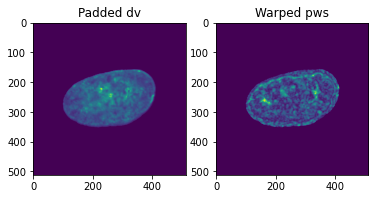

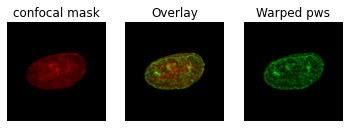

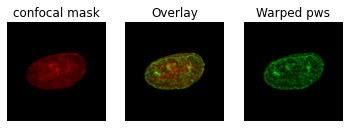

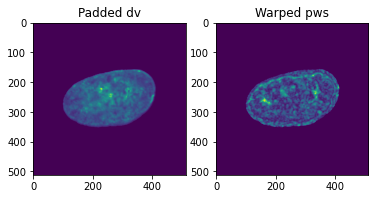

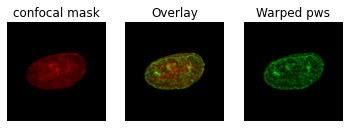

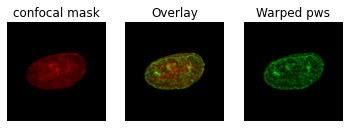

In [135]:
double_img_show(padded_dv,
                registered_pws,
                'Padded dv',
                'Warped pws')
regtools.overlay_images(cell1.padded_dv, cell1.registered_pws, 'confocal mask', 'Overlay', 'Warped pws')
# Higher resolution
# regtools.overlay_images(cell1.padded_dv, cell1.registered_pws, 'confocal mask', 'Overlay', 'Warped pws',osp.join('./Processed/reference_img', f"{cell1.save_name}.png"), dpi=1000)

### 8. Problems

1. Mismatching in pws and confocal (at least in "BJCells_DishB_09_01_2022")
2. Explain the relationship using the overalay image above (Because I can't find any relationship in the picture above, from my eyes)
3. Some confocal boundary error, check!